# Homework 2
#### Name: Syed Zain Raza
#### CWID: 20011917

In [1]:
# optional: allow Jupyter to "hot reload" the Python modules I wrote, to avoid restarting the kernel after every change
%load_ext autoreload
%autoreload 2

## Problem 1: Teddy Stereo

### Part 1: Loading the Images

Going to reuse a helper function I wrote last semester (for CS 558):

In [2]:
from util import ops

In [3]:
left_img = ops.load_image(
    "../datasets/teddy/teddyL.pgm",
    return_grayscale=True,
    return_array=True,
)

Dimensions of ../datasets/teddy/teddyL.pgm: 375 x 450


In [4]:
right_img = ops.load_image(
    "../datasets/teddy/teddyR.pgm",
    return_grayscale=True,
    return_array=True,
)

Dimensions of ../datasets/teddy/teddyR.pgm: 375 x 450


In [5]:
teddy_disparity_map = ops.load_image(
    "../datasets/teddy/disp2.pgm",
    return_grayscale=True,
    return_array=True,
)

Dimensions of ../datasets/teddy/disp2.pgm: 375 x 450


### Part 2: Preprocessing

#### Using the Rank Transform

All new Python code:

In [6]:
import numpy as np

class RankTransform2D:
    """Performs rank filtering on an image."""
    @staticmethod
    def transform(
        image: np.ndarray,
        filter_side_length: int,
        do_logging: bool = False,
    ) -> np.ndarray:
        """
        Produce a new image where each cell value
        represents the "rank" of the corresponding pixel in the input
        (i.e., the index of said pixel in a sorted list of itself &
        the neighboring pixel values).

        Parameters:
            image(np.ndarray): a 2D array representing a single grayscale image
            filter_side_length(int): this is k. The size of each local neighborhood
                              will be kxk. Please pass an odd value > 0.
            do_logging(bool): enables print statements to display intermediate
                              values during execution

        Returns: np.ndarray: the transformed image
        """
        ### HELPER(S)
        def compute_rank(
            image: np.ndarray,
            kernel: np.ndarray,
            row_index: int,
            col_index: int,
        ) -> float:
            """
            Computes the rank of 1 local window of the image.

            Parameters:
                image(array-like): see above
                kernel(array-like): tells us the size of the window
                row_index, col_index: int: the coordinates of the upper left corner
                                            of the block of pixels being ranked

            Returns: int: the rank of the center pixel of the window
            """
            # A: define useful vars
            kernel_h, kernel_w = kernel.shape
            # B: get the block of pixels needed for the convolution
            block_of_pixels = image[
                row_index : (kernel_h + row_index),
                col_index : (kernel_w + col_index)
            ]
            # C: count the of # higher than the center
            center_val = block_of_pixels[kernel_h // 2, kernel_w // 2]
            if do_logging:
                print(f"I think that {center_val} is at the center of {block_of_pixels}")
            transformed_block = np.where(block_of_pixels < center_val, 1, 0)
            if do_logging:
                print(f"Transformed block <{block_of_pixels}> into: <{transformed_block}>")
            return np.sum(transformed_block)

        ### DRIVER
        # data validation
        assert isinstance(image, np.ndarray)
        assert image.shape > (0, 0)
        assert isinstance(filter_side_length, int)
        assert filter_side_length > 0 and filter_side_length % 2 == 1

        # make a copy of the img, padded - will be an intermediate repr
        kernel = np.ones((filter_side_length, filter_side_length))
        padded_image, _, _ = ops.pad(
            image, kernel, stride=1, padding_type="zero"
        )
        # fill in the output
        stride = 1
        output_image = list()
        kernel_h, _ = kernel.shape
        # iterate over the rows and columns
        starting_row_ndx = 0
        while starting_row_ndx <= len(padded_image) - kernel_h:
            # convolve the next row of this channel
            next_channel_row = ops.slide_kernel_over_image(
                padded_image,
                kernel,
                starting_row_ndx,
                stride,
                apply=compute_rank,
            )
            # now, add the convolved row to the list
            output_image.append(next_channel_row)
            # move to the next starting row for the filtering
            starting_row_ndx += stride
        # stack the channels, and return
        return np.array(output_image).squeeze()

#### Test: Rank Transform the Left View

Sanity check to make sure the rank transform produced a new image of the same dimensions as the input:

In [7]:
transformed_left = RankTransform2D.transform(
    left_img, filter_side_length=5, do_logging=False,
)

In [8]:
transformed_left.shape == left_img.shape

True

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

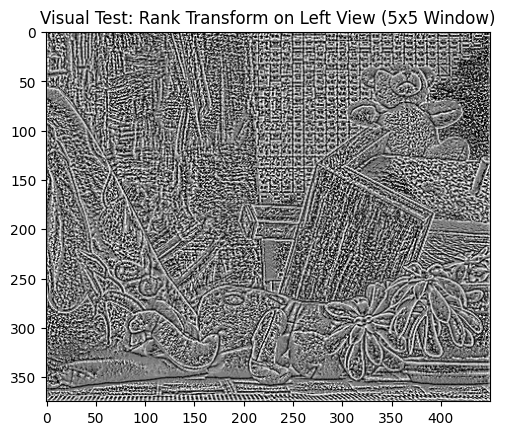

In [10]:
plt.imshow(transformed_left, cmap="gray")
plt.title("Visual Test: Rank Transform on Left View (5x5 Window)")
plt.show()

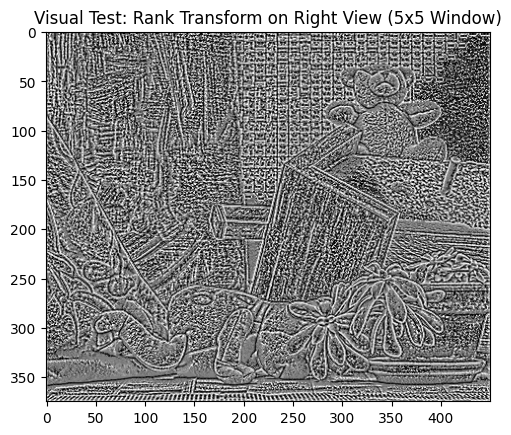

In [11]:
transformed_right = RankTransform2D.transform(
    right_img,
    filter_side_length=5,
    do_logging=False,
)
plt.imshow(transformed_right, cmap="gray")
plt.title("Visual Test: Rank Transform on Right View (5x5 Window)")
plt.show()

### Part 2: Computing a Disparity Map

I initially implemented this to use a triple nested for loop (for every pixel in a row of the left image, for each row in said left image, do a for loop to traverse patches in the corresponding row of the right image) - understandably, that run so slow that it prohibited getting meaningful output.

The implementation below tries to be more efficient by leveraging sorting and vectorization, based on the insight that each row pixel in the left image can only have up to 1 unique correspondence in the right image row. Runs much more quickly. 

And I hope the output disparity map looks decent:

In [16]:
from __future__ import annotations
from dataclasses import dataclass
import functools
from typing import Callable, Literal, Union

import matplotlib.pyplot as plt
import numpy as np

from util import ops
from util.ops import SimilarityMeasure


@dataclass
class SimpleStereoDisparityMap:
    """
    Computes a disparity map between two images based on the
    assumptions that they are:
        1) of the same shape,

        2) grayscale,

        3) and already rectified.
    """
    left_image: np.ndarray
    right_image: np.ndarray
    stride: int = 1
    padding_type: Union[Literal["zero"], Literal["repeat"]] = "zero"

    def compute(
        self: SimpleStereoDisparityMap,
        similarity_measure: SimilarityMeasure,
        rank_transform_filter_side_length: int,
        window_size: int,
        do_logging: bool = False,
        max_disparity_level: int | float = float("inf")
    ) -> np.ndarray:
        """
        Compute pixel-wise disparity by searching in the second image
        the most similar patch along the same row in the first image.

        Parameters:
            similarity_measure(SimilarityMeasure): determines how the hypotheses for the correspondence are determined.
                Currently, only Sum of Absolute Difference (aka `SimilarityMeasure.SAD`) is supported.
            rank_transform_filter_side_length(int): the side length of the kernel used for rank filtering.
            window_size(int): the side length of the window you want to use to compare local patches in the left/right views.
            do_logging(bool): enables certain debugging statements in the code to be reached during execution. Defaults to False.
            max_disparity_level(int | float): if known a priori, we use this as an upper threshold for disparity levels.
                It means that we think that if a disparity > max_disparity_level, there must not actually be any correspondence in
                the right image, for some pixel in the left.

        Returns: np.ndarray: 2D disparity map
        """
        ### HELPER(S)
        def _compute_patch_sum(
                starting_col: np.ndarray,
                starting_row_ndx: int,
                image: np.ndarray,
                kernel_dims: tuple[int, int]  # h, w
            ) -> int:
            """
            Returns the sum of cell values within a small window of an image.

            Parameters:
                starting_col(np.ndarray): shape of (1,), has an integer dtype
                starting_row_ndx(int): index for the top row of the window
                image(nd.ndarray): a grayscale image
                kernel_dims(int, int): height and width of the window

            Returns: int
            """
            kernel_h, kernel_w = kernel_dims
            starting_col_ndx = starting_col[0]
            return np.sum(image[
                starting_row_ndx : int(starting_row_ndx + kernel_h),
                starting_col_ndx : int(starting_col_ndx + kernel_w)
            ])

        def _compute_row_of_disparity_map_sad(
            compute_patch_sum_helper: Callable,
            ptl: np.ndarray,
            ptr: np.ndarray,
            starting_row_ndx: int,
        ) -> np.ndarray:
            """
            Computes a single row of disparity levels based on SAD.

            Parameters:
                compute_patch_sum_helper(function): same as the _compute_patch_sum, but partially
                                                    filled in so it can be used as a 1D function.
                ptl(2D np.ndarray): the left image, after having been rank transformed
                ptr(2D np.ndarray): the right image, after having been rank transformed
                starting_row_ndx(int): index of the top row to use in calculating patch sums

            Returns: np.ndarray: a 1D array of int's
            """
            # get all patches in the left image row
            _, kernel_w = kernel.shape
            left_image_starting_col_indices = np.arange(
                0, ptl.shape[1] - kernel_w + self.stride, self.stride
            ).astype(int).reshape(1, -1)
            left_image_center_col_indices = (left_image_starting_col_indices + (kernel_w // 2)).astype(int).squeeze()

            left_image_patch_sums = np.apply_along_axis(
                func1d=lambda left_image_starting_col: compute_patch_sum_helper(
                    starting_col=left_image_starting_col,
                    image=padded_transformed_left,
                    starting_row_ndx=starting_row_ndx,
                ),
                axis=0,
                arr=left_image_starting_col_indices
            )
            assert left_image_center_col_indices.shape[0] == left_image_patch_sums.shape[0]

            # get all patches in the right image row
            right_image_starting_col_indices = np.arange(
                0, ptr.shape[1] - kernel_w + self.stride, self.stride
            ).astype(int).reshape(1, -1)
            right_image_center_col_indices = (right_image_starting_col_indices + (kernel_w // 2)).astype(int).squeeze()

            right_image_patch_sums = np.apply_along_axis(
                func1d=lambda right_image_starting_col: compute_patch_sum_helper(
                    starting_col=right_image_starting_col,
                    image=padded_transformed_right,
                    starting_row_ndx=starting_row_ndx,
                ),
                axis=0,
                arr=right_image_starting_col_indices
            )
            assert right_image_center_col_indices.shape[0] == right_image_patch_sums.shape[0]

            # match correspondences by sorting
            correspondences = np.zeros((right_image_center_col_indices.shape[0], 2))
            correspondences[:, 0] = left_image_center_col_indices[np.argsort(left_image_patch_sums)]
            correspondences[:, 1] = right_image_center_col_indices[np.argsort(right_image_patch_sums)]

            disparity = np.abs(correspondences[:, 0] - correspondences[:, 1])
            disparity = np.where(disparity > max_disparity_level, 0, disparity)
            if do_logging:
                print(f"left sums: {left_image_patch_sums}")
                print(f"left sums: {right_image_patch_sums}")
                print(f"hypothesized correspondences: {correspondences}")
            assert np.min(disparity) >= 0, f"disparity of {disparity} is too low"
            assert np.max(disparity) <= max_disparity_level, f"disparity of {disparity} is too high"
            return disparity

        ### DRIVER
        # data validations
        assert self.left_image.shape == self.right_image.shape, (
            f"Image shape mismatch between left <{self.left_image.shape}>"
            f" and right <{self.right_image.shape}> views."
        )
        assert len(self.left_image.shape) == 2, (
            f"Expected a 2D array representing a grayscale image, "
            f"actual number of channels is: {self.left_image.shape[2]}."
        )
        # rank transform both images
        transformed_left = RankTransform2D.transform(self.left_image, rank_transform_filter_side_length)
        transformed_right = RankTransform2D.transform(self.right_image, rank_transform_filter_side_length)
        # create a square kernel of all 1's using the given window size
        kernel = np.ones((window_size, window_size))
        # pad both images
        padded_transformed_left, _, _ = ops.pad(
            transformed_left,
            kernel,
            stride=self.stride,
            padding_type=self.padding_type
        )
        ptl: np.ndarray = padded_transformed_left
        padded_transformed_right, _, _ = ops.pad(
            transformed_right,
            kernel,
            stride=self.stride,
            padding_type=self.padding_type
        )
        ptr: np.ndarray = padded_transformed_right
        assert (
            ptl.shape == ptr.shape
        ), f"Shape mismatch after padding: {ptl.shape} != {ptr.shape}"
        # create the output image
        output = np.zeros_like(self.left_image)

        # compute_patch_sum_helper = functools.partial(
        #     _compute_patch_sum,
        #     kernel_dims=kernel.shape,
        # )

        # # for every row in the first image
        # kernel_h, _ = kernel.shape
        # for starting_row_ndx in np.arange(
        #     0, ptl.shape[0] - kernel_h + self.stride, self.stride
        # ).astype(int):
        #     # compute the next row of the output disparity map, using the given similarity metric
        #     disparity = None
        #     if similarity_measure == SimilarityMeasure.SAD:
        #         disparity = _compute_row_of_disparity_map_sad(
        #             compute_patch_sum_helper, ptl, ptr, starting_row_ndx,
        #         )
        #     else:  # similarity_measure is something other than SAD
        #         raise NotImplementedError(
        #             f"Sorry, using similarity_measure = {similarity_measure} is not supported."
        #         )
        #     # fill in the output
        #     output[starting_row_ndx, :disparity.shape[0]] = disparity

        # "Brute force"
        # for each row
        kernel_h, kernel_w = kernel.shape
        output_row_ndx = 0
        for starting_row_ndx in np.arange(0, ptl.shape[0] - kernel_h + self.stride, self.stride):
            # for each pixel
            disparity_row = list()
            for left_starting_col_ndx in np.arange(0, ptl.shape[1] - kernel_w + self.stride, self.stride):
                left_center_col_ndx = left_starting_col_ndx + (kernel_w // 2)
                # init lowest_sum
                lowest_sum, best_center_index = float("inf"), left_center_col_ndx
                left_patch = ptl[starting_row_ndx:starting_row_ndx+kernel_h, left_starting_col_ndx:left_starting_col_ndx+kernel_w]
                disparity_search_range = min(max_disparity_level, left_center_col_ndx)
                disparity_search_stop_index = max(0, left_center_col_ndx - disparity_search_range) - 1
                # for every column (from the current_col to (current_col - disp_level=current_col))
                for right_center_col_ndx in range(left_center_col_ndx, disparity_search_stop_index, -1 * self.stride):

                    # in the right img, same row --> compute every SAD
                    right_starting_col_ndx = right_center_col_ndx - (kernel_w // 2)
                    if right_starting_col_ndx > -1:
                        right_patch = ptr[starting_row_ndx:starting_row_ndx+kernel_h, right_starting_col_ndx:right_starting_col_ndx+kernel_w]
                        sad_val = np.sum(np.abs(left_patch - right_patch))

                        # take the min to get to the disparity
                        if sad_val < lowest_sum:
                            lowest_sum = sad_val
                            best_center_index = right_center_col_ndx

                disparity_row.append(left_center_col_ndx - best_center_index)

            output[output_row_ndx, :] = np.array(disparity_row)
            output_row_ndx += 1

        # final checks
        assert output.shape == self.left_image.shape, f"Shape mismatch {output.shape} != {self.left_image.shape}"
        return output

    @classmethod
    def compute_and_visualize(
        cls: SimpleStereoDisparityMap,
        image1: np.ndarray,
        image2: np.ndarray,
        similarity_measure: SimilarityMeasure,
        rank_transform_filter_side_length: int,
        window_size: int,
        scene_name: str,
        do_logging: bool = False,
        stride: int = 1,
        max_disparity_level: int | float = float("inf"),
        padding_type: Union[Literal["zero"], Literal["repeat"]] = "zero",
    ) -> None:
        """
        Convenience wrapper that both computes and plots
        1 disparity map for a pair of stereo images.

        Parameters:
            image1, image2 (np.ndarrays): the left and right views, respectively
            similarity_measure(SimilarityMeasure): determines how the hypotheses for the correspondence are determined.
                Currently, only Sum of Absolute Difference (aka `SimilarityMeasure.SAD`) is supported.
            rank_transform_filter_side_length(int): the side length of the kernel used for rank filtering.
            window_size(int): the side length of the window you want to use to compare local patches in the left/right views.
            scene_name(str): used for titling the image plot at the end, for the disparity map
            do_logging(bool): enables certain debugging statements in the code to be reached during execution. Defaults to False.
            stride(int): hyperparameter that decides how many "steps" we take when sliding a local window over the images
                (both for the rank filtering and stereo algorithm).
            max_disparity_level(int | float): if known a priori, we use this as an upper threshold for disparity levels.
                It means that we think that if a disparity > max_disparity_level, there must not actually be any correspondence in
                the right image, for some pixel in the left.
            padding_type("zero" | "repeat"): type of padding to use while computing the disparity map

        Returns: None
        """
        mapper: SimpleStereoDisparityMap = cls(
            left_image=image1,
            right_image=image2,
            stride=stride,
            padding_type=padding_type,
        )
        disparity_map = mapper.compute(
            similarity_measure=similarity_measure,
            rank_transform_filter_side_length=rank_transform_filter_side_length,
            window_size=window_size,
            do_logging=do_logging,
            max_disparity_level=max_disparity_level,
        )
        plt.imshow(disparity_map, cmap="gray")
        plt.title(f"Disparity for \"{scene_name}\", {window_size}x{window_size} Window")
        plt.axis("off")

#### Scoring a Disparity Map

Once the disparity map has been estimated, we need a way to report the error rate:

In [17]:
def evaluate_disparity_map(
    predicted: np.ndarray,
    true: np.ndarray,
    scale_factor: int = 1,
    threshold: float = 0,
) -> None:
    """
    Prints the error rate in a disparity levels.

    Assumes both maps are of the same shape.

    Parameters:
        predicted(np.ndarray): the computed disparity map
        true(np.ndarray): the ground truth disparity map
        scale_factor(int): optional, the amount we divide the disparities in
            the ground truth by
        threshold(float): the amount of allowed difference between the
            the disparity maps

    Returns: None
    """
    ground_truth = true.copy() / scale_factor
    difference = np.abs(predicted - ground_truth)
    num_bad_pixels = np.where(difference > threshold, 1, 0).sum()
    num_total_pixels = np.prod(predicted.shape)
    print(f"Error rate: {np.round((num_bad_pixels / num_total_pixels), decimals=4) * 100}%.")


#### Testing the `SimpleStereoDisparityMap` with a 3x3 Window

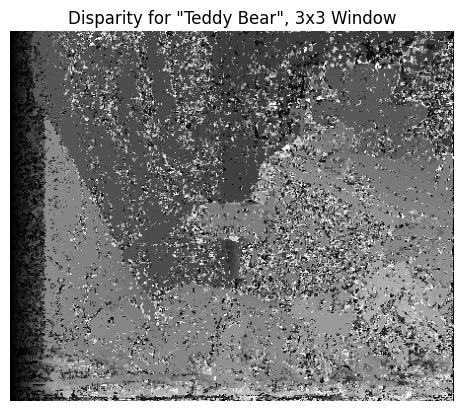

In [18]:
SimpleStereoDisparityMap.compute_and_visualize(
    left_img,
    right_img,
    SimilarityMeasure.SAD,
    rank_transform_filter_side_length=5,
    window_size=3,
    scene_name="Teddy Bear",
    do_logging=False,
    stride=1,
    padding_type="zero",
    max_disparity_level=63,  # given in the assignment description
)

#### Error Rate of `SimpleStereoDisparityMap` in a 3x3 Window

In [19]:
mapper = SimpleStereoDisparityMap(
    left_img,
    right_img,
    stride=1,
    padding_type="zero",
)
disparity_map = mapper.compute(
    similarity_measure=SimilarityMeasure.SAD,
    rank_transform_filter_side_length=5,
    window_size=3,
    do_logging=False,
    max_disparity_level=63,
)
evaluate_disparity_map(
    predicted=disparity_map,
    true=teddy_disparity_map,
    scale_factor=4,
    threshold=1,
)

Error rate: 47.949999999999996%.


#### Testing the `SimpleStereoDisparityMap` with a 15x15 Window

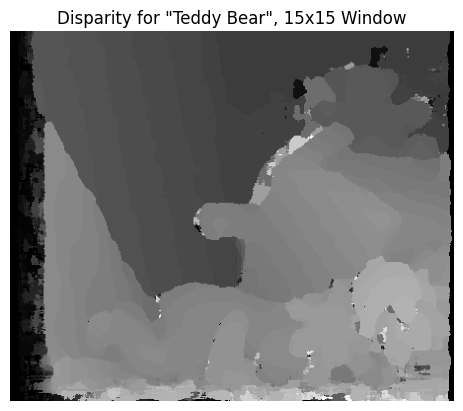

In [20]:
SimpleStereoDisparityMap.compute_and_visualize(
    left_img,
    right_img,
    SimilarityMeasure.SAD,
    rank_transform_filter_side_length=5,
    window_size=15,
    scene_name="Teddy Bear",
    do_logging=False,
    stride=1,
    padding_type="zero",
    max_disparity_level=63,  # given in the assignment description
)

#### Error Rate of `SimpleStereoDisparityMap` in a 15x15 Window

In [21]:
mapper = SimpleStereoDisparityMap(
    left_img,
    right_img,
    stride=1,
    padding_type="zero",
)
disparity_map = mapper.compute(
    similarity_measure=SimilarityMeasure.SAD,
    rank_transform_filter_side_length=5,
    window_size=15,
    do_logging=False,
    max_disparity_level=63,
)
evaluate_disparity_map(
    predicted=disparity_map,
    true=teddy_disparity_map,
    scale_factor=4,
    threshold=1,
)

Error rate: 22.74%.


#### Analysis

The map created with the 15x15 local window fared about 2x better than the one with 3x3 windows, which suggests the results could be improved by using an even larger window. With more time, I would attempt to improve these results by trying out larger window sizes and (to be honest) investigating the code of `RankTransform2D` and `SimpleStereoDisparityMap`, in case I accidentally made any mistakes in my implementation.

## Problem 2: Fish Stereo

### Step 1: Modify the Rendering Code

For this step, I choose to modify the rendering script from the first homework assignment. To modify the code, I added new arguments. To illustrate, the following cell will show you the help text:

P.S.: Notably, I initially tried using the new, faster rendering script based on Open3D - but then I ran into issues. Just FYI, I believe it is due to my using macOS; and outside of class, I'd be very interested to look at this [bug](https://github.com/isl-org/Open3D/issues/5864) that breaks headless rendering on Apple Silicon.



In [18]:
!python util/dolly_data_code_python/dolly_zoom_slow_modified.py --help

usage: dolly_zoom_slow_modified.py [-h]
                                   [--use-max-filter | --no-use-max-filter]
                                   [--resolution-scale-factor RESOLUTION_SCALE_FACTOR]
                                   [--save-dir SAVE_DIR]
                                   [--use-depth-logging | --no-use-depth-logging]
                                   [--num-frames NUM_FRAMES]

options:
  -h, --help            show this help message and exit
  --use-max-filter, --no-use-max-filter
                        turn on/off 2D max_filtering
  --resolution-scale-factor RESOLUTION_SCALE_FACTOR
                        A multiplier used to reduce the image heightxwidth
                        (from the default of 2048x3072).
  --save-dir SAVE_DIR   Relative path to a folder for storing rendered images.
  --use-depth-logging, --no-use-depth-logging
                        Print the closest and farthest depth of 3D scene
                        points (assumed to be in meters)

Based on the above, I want to highlight that:

1. if the user passes `--resolution-scale-factor=4`, the image pixel resolution will be `1/4` of the default.

1. Likewise, to keep the FOV unchanged, we scale the camera intrinsics (specifically, the focal lengths in X and Y; and the principal point coordinates) by `1 / (resolution_scale_factor / 2)` - so in this case, we'd by multiplying by `1/2`.  

1. Thirdly, I added a `--no-use-max-filter` option to prevent the code from performing a 2D max filter operation.

### Step 2: Design the Stereo Geometry and Disparity Search Parameters

For rendering, I tried to keep the extrinsic parameters simple:

1. the rotation matrix `R` would remain as a 3x3 identity matrix, `I`, so the epipolar lines would be parallel (I believe that would help with rectification).

2. the translation vector `t` only changes the camera's coordinates in world space along the X-axis. It is hardcoded into the rendering script, named `dolly_zoom_slow_modified.py`, as `move = np.array([0.155, 0.0, 0]).reshape((3, 1))`. 

With this kind of camera motion, the disparity can be computed just as in problem 1: by using `SimpleStereoDisparityMap` to search along image rows for potential pixel correspondences.



#### Stereo Baseline 

I have log lines in the rendering script, named `dolly_zoom_slow_modified.py`, that display the camera extrinsic matrices used for both of the images I rendered for this problem. 

Given this info, we can write a function to compute the stereo camera baseline:


In [49]:
def compute_stereo_camera_baseline(
    R1: np.ndarray, t1: np.ndarray,
    R2: np.ndarray, t2: np.ndarray
) -> float:
    """
    Calculate the baseline in meters.

    Parameters:
        R1(np.ndarray): 3x3 rotation matrix for the 1st image
        t1(np.ndarray): 3x1 translation vector for the 2nd image
            (units assumed to be in meters)
        R2(np.ndarray): 3x3 rotation matrix for the 2nd image
        t2(np.ndarray): 3x1 translation vector for the 2nd image
            (units assumed to be in meters)

    Returns: float: the stereo camera basline
    """
    camera_center_1 = (-1 * np.linalg.inv(R1)) @ t1
    camera_center_2 = (-1 * np.linalg.inv(R2)) @ t2
    return np.linalg.norm(camera_center_1 - camera_center_2, ord=2)

From having run the script before (I will share the exact command string in the cells below), I was able to discern what exact `[R | t]` values were used for both of my images (will show what they look like below also).

For now, let's use that info to compute the stereo camera baseline:

In [50]:
R1 = R2 = np.eye(3)
t1 = np.array([[0], [0], [0]]).reshape(3, 1)
t2 = np.array([[0.155], [0], [0]]).reshape(3, 1)

In [51]:
baseline = compute_stereo_camera_baseline(R1, t1, R2, t2)
print(f"Stereo camera baseline: {baseline} m.")

Stereo camera baseline: 0.155 m.


#### Disparity range to evaluate

Based on other log lines I put in the rendering script, we also know:

1. the focal length of the camera

2. the min/max depth values along the Z-axis of the scene (considering the points on the statue that are closest to the camera, to the background points that are the furthest away.)

Using this info and the formula `d = bf / Z`, we can compute the range of disparity levels for our stereo images:

In [16]:
def compute_disparity_from_depth(baseline: float, focal_length: float, depth: float) -> float:
    """
    Utilize the relationship d = b*f / Z to arrive at disparity.
    """
    b, f, Z = baseline, focal_length, depth
    return (b * f) / Z

In [17]:
lower_end_Z, upper_end_Z = [3.866280555725098, 9.656695365905762]  # taken from rendering logs
focal_length = 1.37975e03  # this is AFTER changes made by changing the resolution have been applied

In [20]:
lower_end_disparity = compute_disparity_from_depth(baseline, focal_length, lower_end_Z)
upper_end_disparity = compute_disparity_from_depth(baseline, focal_length, upper_end_Z)
disparity_range = int(abs(lower_end_disparity - upper_end_disparity))
print(f"Disparity range to evaluate (in pixels): {disparity_range}.")

Disparity range to evaluate (in pixels): 33.


OK! Based on the above cell, my disparity search will assume correspondences are no more than `33` pixels apart, in the horizontal direction. 

### Step 3: Run Stereo

For background, this is the CLI command I ran (offline) to render the new stereo images:

```bash
$ python -m src.util.dolly_data_code_python.dolly_zoom_slow_modified \
--use-depth-logging \                                  
--no-use-max-filter \
--resolution-scale-factor 4 \
--save-dir "./generated-images/problem2/" \
--num-frames 2
```

Below, let's see how the renders came out:

In [39]:
right_fish_image = ops.load_image(
    "../generated-images/problem2/StereoOutput0.jpg",
    return_grayscale=False,  # will do custom conversion to grayscale below
    return_array=True,
)

Dimensions of ../generated-images/problem2/StereoOutput0.jpg: 1025 x 1537 x 3


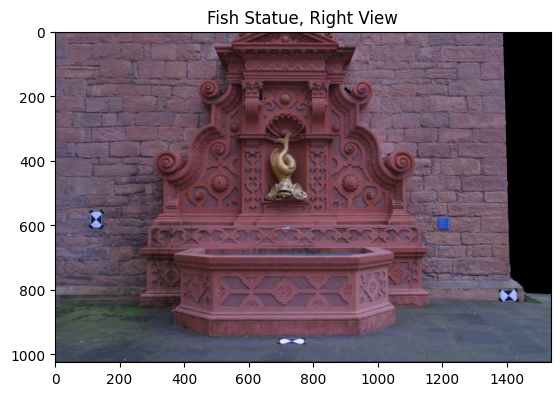

In [40]:
plt.imshow(right_fish_image)
plt.title("Fish Statue, Right View")
plt.show()

In [41]:
left_fish_image = ops.load_image(
    "../generated-images/problem2/StereoOutput1.jpg",
    return_grayscale=False,  # will do custom conversion to grayscale below
    return_array=True,
)

Dimensions of ../generated-images/problem2/StereoOutput1.jpg: 1025 x 1537 x 3


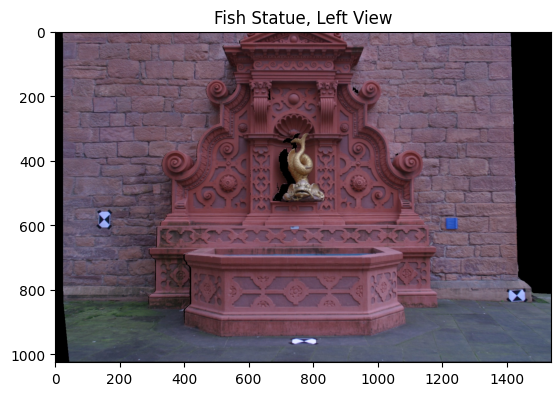

In [42]:
plt.imshow(left_fish_image)
plt.title("Fish Statue, Left View")
plt.show()

#### Part A: Convert RGB to Grayscale

This will be just like in problem 1. The one slight change is our images are now RGB, not grayscale - so we'll need to preprocess to be so before running the stereo algorithm.

In [44]:
convert_rgb_to_gray = lambda image: np.squeeze(
    # formula taken from the HW 3 pdf description
    (0.3 * image[:, :, 0]) +  # red
    (0.59 * image[:, :, 1]) +  # green
    (0.11 * image[:, :, 2])  # blue
)

In [46]:
left_fish_image_gray = convert_rgb_to_gray(left_fish_image)
left_fish_image_gray.shape  # sanity check on the image dimensions

(1025, 1537)

In [47]:
right_fish_image_gray = convert_rgb_to_gray(right_fish_image)
right_fish_image_gray.shape  # sanity check

(1025, 1537)

#### Part B: Running the Stereo Algorithm 

Since the 15x15 window performed better in terms of error rate in problem 1, I will reuse it here. And the max threshold for the disparity will be 33. 

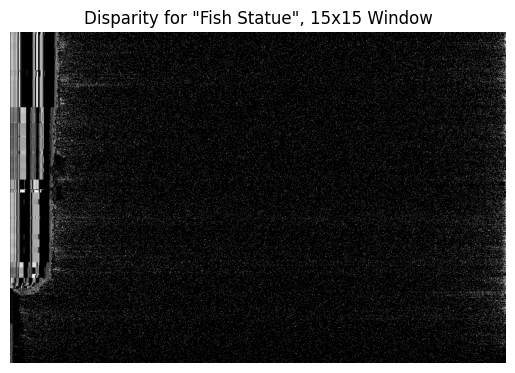

In [48]:
SimpleStereoDisparityMap.compute_and_visualize(
    left_fish_image_gray,
    right_fish_image_gray,
    SimilarityMeasure.SAD,
    rank_transform_filter_side_length=5,
    window_size=15,
    scene_name="Fish Statue",
    do_logging=False,
    stride=1,
    padding_type="zero",
    max_disparity_level=33,
)